# $n$-step TD on a random walk

We consider a modified random Markov process (MRP) presented in example 6.2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from numba import njit, prange
from itertools import product

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
np.set_printoptions(linewidth=150, suppress=True, precision=4)

# Algebraic value estimation

Let ${\cal S} = \{1, \ldots, S\}$ be the collection of possible states.
Being in any state,
one moves to the right or to the left with equal probability,
as long as the state is not in the boundary.

More formally, suppose $s, s' \in {\cal S}$
are the initial state and subsequent states respectively.
Then,
$$
    p(S'=s' | S=s) =
    \begin{cases}
    \frac{1}{2} & \text{if } s' = s+ 1,\\
    \frac{1}{2} & \text{if } s' = s - 1,\\
    0 & \text{otherwise}.
    \end{cases}
$$
for $s \not\in\partial{\cal S} = \{1,S\}$.

If $s \in \partial{\cal S}$, then
$$
    p(S'=s' | s) =
    \begin{cases}
        \frac{1}{2} & s' = \texttt{END}\\
        \frac{1}{2} & s' \neq \texttt{END}\\
    \end{cases}
$$

Furthermore, let $\rho$ be the reward. We have
$$
    \rho =
    \begin{cases}
    0 & s \not \in {\cal S},\\
    -1 & s = 1,\\
    1 & s = S.
    \end{cases}
$$

```
END-L <--- s(1) <---> s(2) <---> ... <---> s(S-1) <---> s(S) --> END-R
 |          |          |                    |           |        |
 [-1]      [0]        [0]                  [0]         [0]      [1] 
```


### Value expectations
Our goal is to estimate $\mathbb{E}[\rho | S=s]$ for all $S \in {\cal S}$.

In general, we have
$$
\begin{aligned}
    \mathbb{E}[\rho | S=s]
    &= \sum_{\rho \in \{0,-1,1\}} \rho\,p(\rho \vert s)\\
    &= \sum_{\rho \in \{0,-1,1\}} \sum_{s'\in{\cal S}} \rho\,p(\rho, s' \vert s)\\
    &= \sum_{\rho \in \{0,-1,1\}} \sum_{s'\in{\cal S}} \rho\,p(s' \vert s)\,p(\rho | s, s')\\
    &= \sum_{s'\in{\cal S}}p(s' \vert s)\,\sum_{\rho \in \{0,-1,1\}} \rho\,p(\rho | s, s')\\
    &= \sum_{s'\in{\cal S}}p(s' \vert s)\,\sum_{\rho \in \{0,-1,1\}} \rho\,p(\rho | s')\\
    &= \sum_{s'\in{\cal S}}p(s' \vert s)\,\mathbb{E}[\rho | S'='s]
\end{aligned}
$$

If $s \not\in\partial{\cal S}$,
$$
\begin{aligned}
    \mathbb{E}[\rho | S=s]
    &= \sum_{s'\in\{s + 1, s-1\}}p(s' \vert s)\,\mathbb{E}[\rho | S'=s']\\
    &= \frac{1}{2}\mathbb{E}[\rho |s+1] + \frac{1}{2}\mathbb{E}[\rho |s-1]
\end{aligned}
$$

If $s = 1$,
$$
\begin{aligned}
    \mathbb{E}[\rho | S=1]
    &= \sum_{s'\in\{\texttt{END}, 2\}}p(s' \vert s)\,\mathbb{E}[\rho | S'=s']\\
    &= \frac{1}{2}\mathbb{E}[\rho | \texttt{END-L}] + \frac{1}{2}\mathbb{E}[\rho |2]\\
    &= \frac{1}{2}\,-1 + \frac{1}{2}\mathbb{E}[\rho |2]\\
\end{aligned}
$$


If $s = S$,
$$
\begin{aligned}
    \mathbb{E}[\rho | S=S]
    &= \sum_{s'\in\{S-1, \texttt{END-R}\}}p(s' \vert s)\,\mathbb{E}[\rho | S'='s]\\
    &= \frac{1}{2}\mathbb{E}[\rho | S-1] + \frac{1}{2}\mathbb{E}[\rho | \texttt{END-R}]\\
    &= \frac{1}{2}\mathbb{E}[\rho | S-1] + \frac{1}{2}\,1\\
\end{aligned}
$$

### Solving the sytem of equations

Let $\rho_s \triangleq \mathbb{E}[\rho \vert S=s]$,
then, we have the following system of equations.
(Below, $s\not\in\partial{\cal S}$)

$$
\begin{aligned}
    \rho_1 &= \frac{1}{2}\rho_2 - \frac{1}{2}\\
    \rho_s &= \frac{1}{2}\rho_{s+1} + \frac{1}{2}\rho_{s-1}\\
    \rho_S &= \frac{1}{2}\rho_{S-1} + \frac{1}{2}
\end{aligned}
$$

Rearranging
$$
\begin{aligned}
    \rho_1 - \frac{1}{2}\rho_2 &= -\frac{1}{2}\\
    - \frac{1}{2}\rho_{s+1} + \rho_s - \frac{1}{2}\rho_{s-1} &= 0\\
    - \frac{1}{2}\rho_{S-1} + \rho_S &= \frac{1}{2}
\end{aligned}
$$

Finally, we write the system above as 
$$
    {\bf A}\,\boldsymbol\rho = {\bf y}
$$
with
$$
    \boldsymbol\rho =
    \begin{bmatrix}
    \rho_1\\
    \rho_2\\
    \vdots \\
    \rho_S
    \end{bmatrix}
$$

$$
{\bf A} =
\begin{bmatrix}
1 & -0.5 & 0 & 0 & \cdots & 0 & 0\\
-0.5 & 1 & -0.5 & 0 & \cdots & 0 & 0\\
0 & -0.5 & 1 & -0.5 & \cdots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \cdots & -0.5 & 1
\end{bmatrix}
$$

$$
{\bf y} =
\begin{bmatrix}
-0.5 \\ 0 \\ \vdots \\ 0 \\ 0.5
\end{bmatrix}
$$

In [23]:
n = n_states -1
A = np.eye(n)
A = A - np.eye(n, k=1) / 2 - np.eye(n, k=-1) / 2
y = np.zeros(n)
y[0] = -1/2
y[-1] = 1/2

In [24]:
A

array([[ 1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5,  1. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0

In [22]:
y

array([-0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5])

In [27]:
# Expected value of rewards
value_array = np.linalg.solve(A, y)
value_array

array([-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

# Numerical estimation

The state-value update using TD-1 is
$$
V(S_t) \gets V(S_t) + \alpha\left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)\right].
$$

The state-value update using TD-2 is
$$
V(S_t) \gets V(S_t) + \alpha\left[ R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2}) - V(S_t) \right].
$$

For any $n>2$, the state-value update of TD-$n$ is
$$
V(S_t) \gets V(S_t) + \alpha\left[
    \underbrace{
    \sum_{k=1}^n \gamma^{k-1} R_{t+k} + \gamma^n V(S_{t+n})
    }_{G_{t:t+n}}
    - V(S_t)
    \right].
$$

**Note**: for an episode with $T$ timesteps, if $n \geq T$, then TD reduces to an MC update.

In [28]:
n_states = 19 + 1 # total state plus terminal state
states = np.arange(n_states)
mrp = np.zeros((n_states, n_states))
mrp[0, 0] = 1.0

for i in range(1, n_states):
    iprev = i - 1
    inext = (i + 1) % n_states
    mrp[i, [i - 1, inext]] = 1/2

mrp

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0

In [29]:
@njit
def set_seed(seed):
    np.random.seed(seed)


@njit
def sample_run(s):
    s_hist = [s]
    r_hist = []
    r = 0
    while s != 0:
        snext = np.random.multinomial(1, mrp[s]).argmax()
        r = 1 if (s == n_states - 1) and (snext == 0) else 0
        s = snext
        s_hist.append(s)
        r_hist.append(r)
    
    s_hist = np.array(s_hist[:-1])
    r_hist = np.array(r_hist)
    return s_hist, r_hist

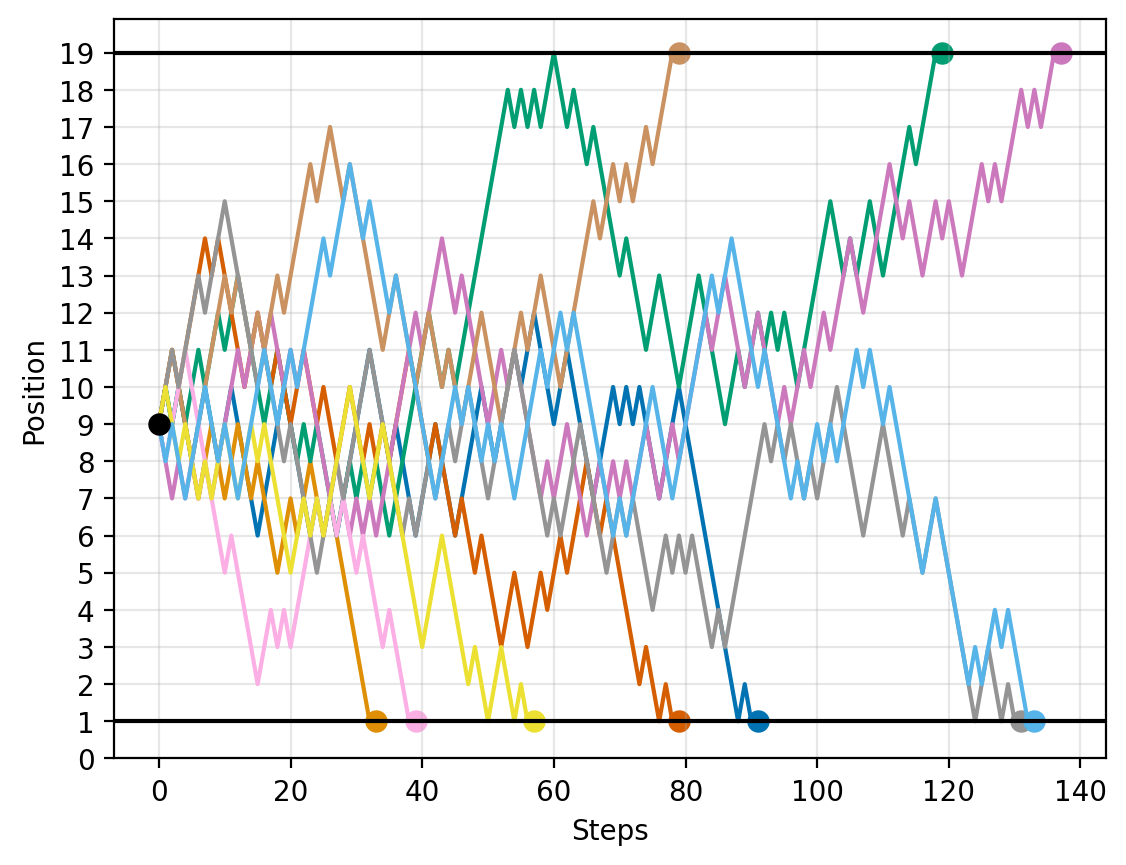

In [30]:
n_sims = 10
s_init = 9

set_seed(3141)
for n in range(n_sims):
    s_hist, r_hist = sample_run(s_init)
    len_hist = len(s_hist)
    plt.plot(s_hist)
    plt.scatter(len_hist, s_hist[-1], s=50)

plt.scatter(0, s_init, c="black", zorder=2, s=50)
plt.axhline(y=n_states - 1, c="black")
plt.axhline(y=1, c="black")
plt.ylabel("Position")
plt.xlabel("Steps")
plt.yticks(np.arange(0, n_states))
plt.grid(alpha=0.3)

In [31]:
@njit
def compute_reward(sprev, snext):
    if (sprev == n_states - 1) and (snext == 0):
        r = 1
    elif (sprev == 1) and (snext == 0):
        r = -1
    else:
        r = 0

    return r


@njit
def tdn_run_single(value, s, alpha, gamma, td_size):
    """
    Sample from the MRP and update the TD-n algorithm
    ----
    Parameters:
    value: np.array
        Current value estimate
    s: float
        initial state
    alpha: float
        learning rate
    gamma: float
        discount
    rewards_td: np.array
        FIFO buffer of rewards
    """
    value = value.copy()
    
    rewards_td = np.zeros(td_size) * np.nan # rewards in the buffer
    states_td = -np.ones(td_size, dtype=np.int32) # states S_{t+n} to update
    discount_array = gamma ** np.arange(td_size)
    # Place initial state in last element of the buffer.
    # Roll it back until hitting the pair (S(1), S(tau))
    states_td[-1] = s

    # Run simulation and fill buffer
    while s != 0:
        # 1. take action
        s_fwd = np.random.multinomial(1, mrp[s]).argmax()
        
        # 2. observe reward and store in buffer:
        #    include element in the last position and
        #    remove the first one.
        r = compute_reward(s, s_fwd)
        
        rewards_td = np.roll(rewards_td, -1)
        rewards_td[-1] = r
        
        # 3. If the buffer is not full, we haven't reached the pair S_τ -> S_{τ+n}.
        #    We d
        # 3. Update the value function only if we have reached the pair (S(t), S(t+n))
        if not np.any(np.isnan(rewards_td)):
            # 3.1 Update state-value function with lag td_size
            s_init = states_td[0]
            target = (discount_array * rewards_td).sum() + (gamma ** td_size) * value[s_fwd]
            value[s_init] = value[s_init] + alpha * (target - value[s_init])

        states_td = np.roll(states_td, -1)
        states_td[-1] = s_fwd
        s = s_fwd

    # 4. Exhaust elements in the buffer MC style:
    #    update a state based on the discounted future returns only.
    for i, s in enumerate(states_td, 1):
        if (s == -1): # invalid state, move to next one
            continue
        elif s == 0: # terminal state
            break

        subset = rewards_td[i:]
        lsubset = len(subset)
        discounts = gamma ** np.arange(lsubset)
        G = (discounts * subset).sum()
        value[s] = value[s] + alpha * (G - value[s])

    return value


@njit
def tdn_run_episodes(value_init, state_init, alpha, gamma, td_size, n_episodes):
    """
    Run the MRP 'n_episodes' times and update the value function
    """
    value = value_init.copy()
    for e in range(n_episodes):
        value = tdn_run_single(value, state_init, alpha, gamma, td_size)
    return value


@njit(parallel=True)
def tdn_value_sims(value_init, state_init, alpha, gamma, td_size, n_episodes, n_sims):
    """
    Run the MRP 'n_episodes' times and update the value function.
    We do this 'n_sims' times and store the array.
    """
    n_states = len(value_init)
    value_all = np.zeros((n_sims, n_states))
    for n in prange(n_sims):
        value = tdn_run_episodes(value_init, state_init, alpha, gamma, td_size, n_episodes)
        value_all[n] = value
    return value_all

## Run experiment

In [32]:
value_init = np.zeros(n_states)

gamma  = 1.0
sinit = 9

n_episodes = 10
n_sims = 10

In [33]:
n_values =[2 ** n for n in range(10)]
alpha_values = np.concatenate((np.linspace(0, 0.1, 10), np.linspace(0.1, 1, 20)[1:-1]))

In [34]:
def experiment(value_init, state_init, alpha_values, td_size_values, gamma, n_episodes, n_sims, n_runs):
    """
    Run `tdn_value_sims` and compute the root mean squared error between the predicted value function
    and the true value function. This procedure is done `n_runs` times.
    """
    collection = []
    for boot in tqdm(range(n_runs)):
        for td_size, alpha in product(td_size_values, alpha_values):
            value = tdn_value_sims(value_init, state_init, alpha, gamma, td_size, n_episodes, n_sims)
            value[value == -1] = np.nan
        
            err = np.nanmean(np.power(value[:, 1:] - value_array, 2), axis=-1)
            err = np.nanmean(np.sqrt(err))

            collection.append((
                td_size, alpha, err, boot
            ))
    return collection

In [35]:
n_runs = 100
collection = experiment(
    value_init, sinit, alpha_values, n_values, gamma, n_episodes, n_sims, n_runs
)

columns = ["n", "alpha", "rmse", "boot"]

collection = [{
    col: val
    for col, val in zip(columns, entry)
} for entry in collection]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.                                              | 0/100 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


In [36]:
res = pd.DataFrame(collection)

In [37]:
colors = plt.cm.viridis(np.linspace(0, 1, len(n_values)))

Text(0.5, 0, '$\\alpha$')

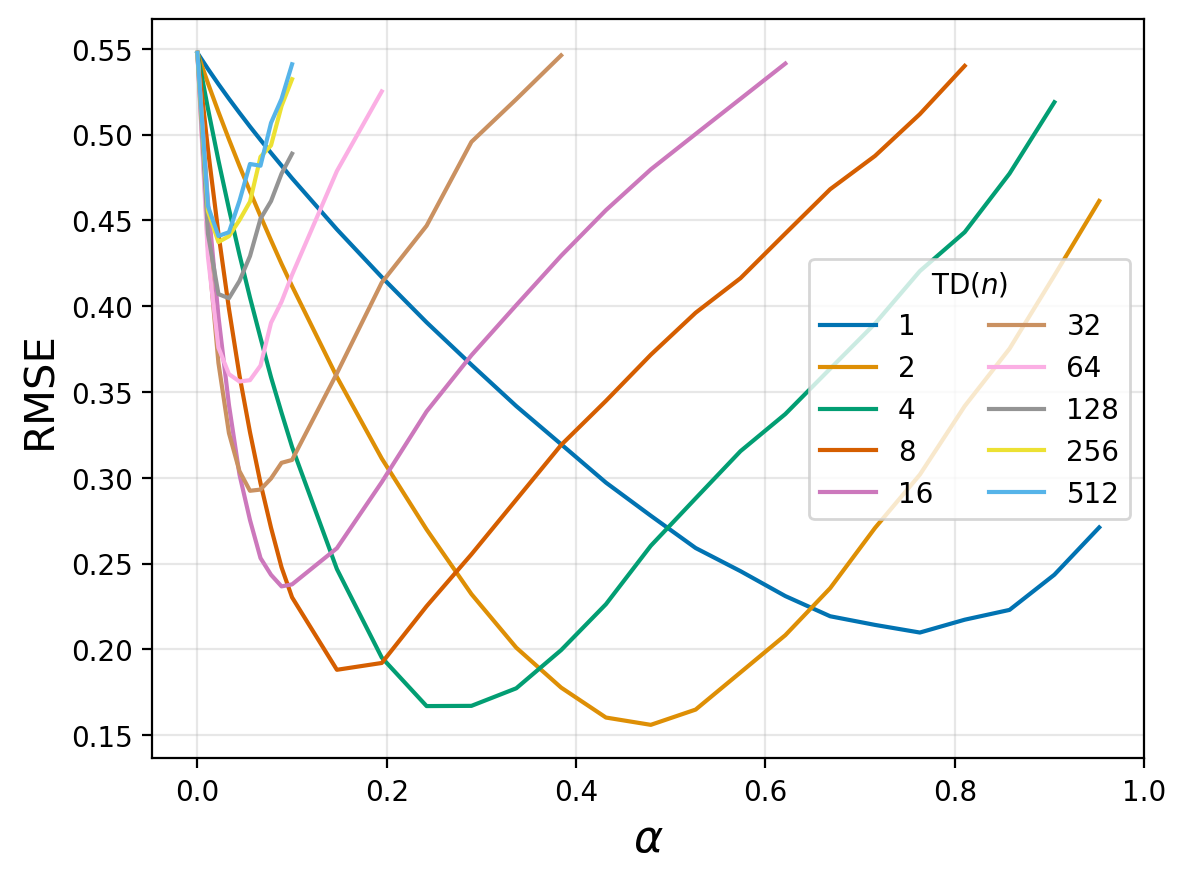

In [38]:
for c, n in zip(colors, n_values):
    res.query("n == @n").groupby("alpha")[["rmse"]].mean().query("rmse <= 0.55")["rmse"].plot(label=n)
plt.grid(alpha=0.3)
plt.ylabel("RMSE", fontsize=15)
plt.legend(ncol=2, title="TD$(n)$")
plt.xlabel(r"$\alpha$", fontsize=16)
# plt.savefig("tdn-experiment.png", dpi=300)